In [1]:
# AWS imports
import boto3
import sagemaker
import os
from datasets import load_dataset
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize
from bertopic import BERTopic
import sagemaker
import pandas as pd


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
# SageMaker session
session = sagemaker.Session()
bucket = session.default_bucket()
prefix = "bertopic-yelp"
s3 = boto3.client("s3")

In [2]:
# 1. Dataset

# the dataset is actually "yelp_review_full"
s3 = boto3.client("s3")
s3.download_file(bucket, "datasets/reviews.csv", "reviews_downloaded.csv")

texts = pd.read_csv("reviews_downloaded.csv")
texts = texts["review"].astype(str).tolist()

In [3]:
# 2. Lemattization

nlp = spacy.load("en_core_web_sm")

def preprocess(given_texts):
    cleaned = []
    for doc in nlp.pipe(given_texts, disable=["ner", "parser"]):
        tokens = [
            t.lemma_.lower() for t in doc
            if not t.is_stop and not t.is_punct and len(t) > 2
        ]
        cleaned.append(" ".join(tokens))
    return cleaned


texts_clean = preprocess(texts)



['goldberg offer look general practitioner nice easy talk patronize time see patient affiliate notch hospital nyu parent explain important case happen need surgery referral specialist have need sit try think complaint draw blank', 'unfortunately frustration dr. goldberg patient repeat experience doctor nyc good doctor terrible staff staff simply answer phone usually take hour repeat call answer time want deal run problem doctor office worker patient medical need answer phone incomprehensible work aggravation regret feel dr. goldberg star', 'go dr. goldberg year think 1st patient start mhmg great year big picture gyn dr. markoff find fibroid explore option patient understanding judge ask right question thorough want keep loop aspect medical health life', 'got letter mail week say dr. goldberg move arizona new position june miss \\n\\ni think find new doctor nyc actually like awful try find date', 'know dr. goldberg like move arizona let tell stay away doctor office go dr. johnson leave 

In [ ]:
# 3. Vectorizer

vectorizer_model = CountVectorizer(
    stop_words="english",
    ngram_range=(1,2),
    min_df=2,
    max_df=0.9
)

In [5]:
# 4. Sentence embeddings

embedding_model = SentenceTransformer("all-mpnet-base-v2")
embeddings = embedding_model.encode(texts_clean, show_progress_bar=True)
embeddings = normalize(embeddings)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [18]:
# 5. BERTopic


topic_model = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    nr_topics="auto",
    language="english"
)

topics, probs = topic_model.fit_transform(texts_clean, embeddings)


In [ ]:
# Local save
model_file = "bertopic_yelp_model.pkl"  # salvăm ca fișier, nu folder
topic_model.save(model_file)

# upload folder recursiv
session.upload_data(path=model_dir, bucket=bucket, key_prefix=f"{prefix}/model")
print(f"Model uploaded to s3://{bucket}/{prefix}/model")

   Topic  Count                            Name  \
0     -1    352       -1_food_order_cheese_nthe   
1      0    104  0_pittsburgh_food_salt_amazing   
2      1     74     1_chinese_food_chicken_wing   
3      2     62      2_food_wait_order_terrible   
4      3     50      3_food_irish_breakfast_bar   
5      4     50   4_store_item_selection_thrift   
6      5     41      5_pizza_order_crust_hoagie   
7      6     39          6_tire_car_repair_need   
8      7     34      7_vegan_foods_food_produce   
9      8     33          8_bar_order_food_table   

                                      Representation  \
0  [food, order, cheese, nthe, eat, night, restau...   
1  [pittsburgh, food, salt, amazing, pizza, resta...   
2  [chinese, food, chicken, wing, sauce, eat, ord...   
3  [food, wait, order, terrible, staff, server, m...   
4  [food, irish, breakfast, bar, beer, pretty, gl...   
5  [store, item, selection, thrift, shop, target,...   
6  [pizza, order, crust, hoagie, pizza place, 

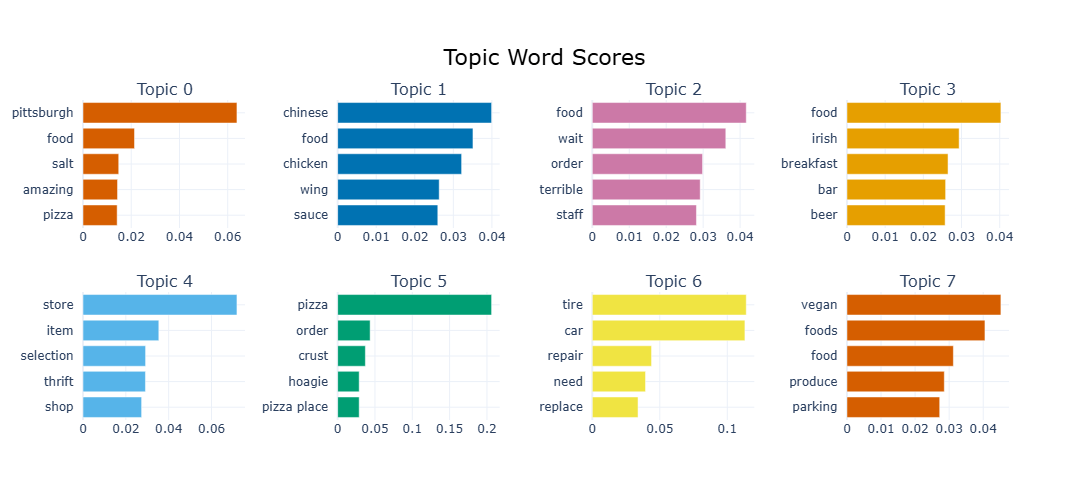

In [11]:

topic_model.visualize_topics()
topic_model.visualize_barchart()
